# **🌾 Clustering des Parcelles de Riz : Découverte de Profils Agricoles Optimisés**

---


**🎯 Objectif de l’analyse**

Segmenter les 2 790 parcelles du dataset Paddy en groupes homogènes selon leurs caractéristiques agronomiques, afin d’identifier des profils d’agriculteurs typiques et reproductibles.

**🔍 Pourquoi cette analyse est pertinente ?**

Le dataset contient 45 variables riches et détaillées, couvrant :

- Intrants : engrais (DAP, Urée, Potasse), pesticides, paille recyclée
- Conditions culturales : surface, variété, densité de semis
- Rendement : de 5 000 à 40 000 kg par parcelle — une variabilité énorme !
- Facteurs environnementaux : température, pluviométrie, type de sol

Cette diversité cache probablement des stratégies agricoles distinctes, qu’un simple résumé statistique ne révèle pas.


**📊 Hypothèses de profils attendus**

*Profil intensif*

- → Hauts intrants, haut rendement

- → Modèle de performance maximale

*Profil extensif*

- → Faibles intrants, rendement faible

- → Identification de contraintes (économiques, informationnelles)

*Profil optimal*

- → Intrants modérés, rendement élevé

- → Meilleures pratiques reproductibles

*Profil inefficace*

- → Hauts intrants, rendement faible

- → Anomalies à investiguer (sol, gestion, stress climatique)


**💡 Applications concrètes**

- Conseils personnalisés : adapter les recommandations aux profils (ex: passer d’extensif à optimal).
- Transfert de bonnes pratiques : diffuser les stratégies du profil « optimal » vers les autres.
- Détection d’anomalies : identifier les parcelles sous-performantes malgré des intrants élevés.
- Politiques publiques : cibler les subventions ou formations selon le profil dominant dans une région.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ML & Clustering
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.model_selection import train_test_split
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.tree import plot_tree
from sklearn.metrics import silhouette_score
from kneed import KneeLocator
from scipy.cluster.hierarchy import linkage, dendrogram

import umap
import os
# suppress warnings
import warnings
warnings.filterwarnings("ignore")


In [2]:
# Configuration des graphiques
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_style("whitegrid")

sns.set_palette("husl")

In [3]:
# Charger le fichier original
df = pd.read_csv('data/paddy_dataset_fe.csv', sep=',', encoding='utf-8', low_memory=False)
# Création d'une copie pour ne pas modifier df original
df_clus = df.copy()

In [4]:
# Aperçu des premières lignes
print("APERÇU DES DONNÉES:")
print("-" * 30)
print(df_clus.head())
print()

APERÇU DES DONNÉES:
------------------------------
   Hectares   Seedrate(in Kg)  LP_Mainfield(in Tonnes)  Nursery area (Cents)  \
0        6.0            150.0                     75.0                 120.0   
1        6.0            150.0                     75.0                 120.0   
2        6.0            150.0                     75.0                 120.0   
3        6.0            150.0                     75.0                 120.0   
4        4.0            150.0                     75.0                 120.0   

   LP_nurseryarea(in Tonnes)  DAP_20days  Weed28D_thiobencarb  Urea_40Days  \
0                        6.0       240.0                 12.0       162.78   
1                        6.0       240.0                 12.0       162.78   
2                        6.0       240.0                 12.0       162.78   
3                        6.0       240.0                 12.0       162.78   
4                        6.0       240.0                 12.0       162.78   


In [5]:
# Garder uniquement les colonnes numériques
numeric_cols = df_clus.select_dtypes(include=[np.number]).columns.tolist()
X = df_clus[numeric_cols].copy()

In [6]:
# Standardiser sur TOUT le jeu de données
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## 1. Dimensionality Reduction Visualizations

### 1.1 PCA (Principal Component Analysis)

Explained variance ratio: [0.23950744 0.23518866]
Total explained variance (PC1 + PC2): 0.4747


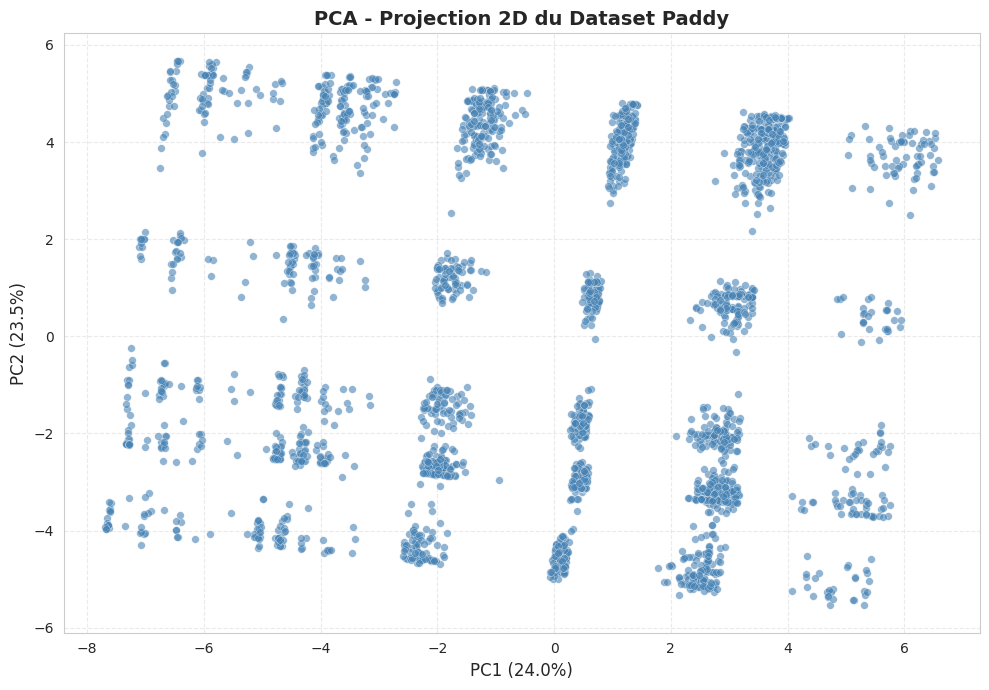

In [7]:
# Appliquer PCA à 2 composantes
pca_2d = PCA(n_components=2, random_state=42)
X_pca_2d = pca_2d.fit_transform(X_scaled)

# Afficher la variance expliquée
print(f'Explained variance ratio: {pca_2d.explained_variance_ratio_}')
print(f'Total explained variance (PC1 + PC2): {pca_2d.explained_variance_ratio_.sum():.4f}')

# Visualisation
plt.figure(figsize=(10, 7))
plt.scatter(X_pca_2d[:, 0], X_pca_2d[:, 1],
            c='steelblue', s=30, alpha=0.6, edgecolors='white', linewidth=0.3)
plt.xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]:.1%})', fontsize=12)
plt.ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]:.1%})', fontsize=12)
plt.title('PCA - Projection 2D du Dataset Paddy', fontsize=14, fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

**Axes :**
- X (PC1) : Explique 24,0 % de la variance totale.
- Y (PC2) : Explique 23,5 % de la variance totale.

Variance totale expliquée par PC1 + PC2 : 47,5 % (soit presque la moitié des données).

> Cela signifie que les deux premières composantes principales capturent presque la moitié de l’information du jeu de données à 45 dimensions, ce qui est assez bon pour une visualisation.

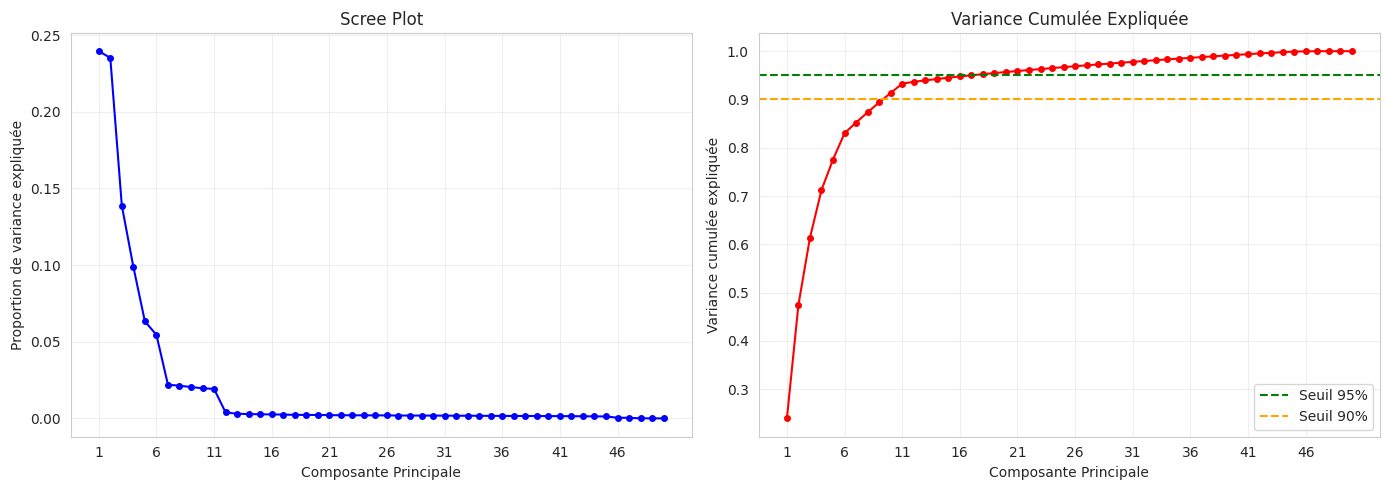


Pour conserver :
   - 90% de la variance → 10 composantes
   - 95% de la variance → 17 composantes


In [8]:
# PCA - Scree plot et variance cumulée
pca_full = PCA()
pca_full.fit(X_scaled)

# Nombre total de composantes = nombre de features
n_features = X_scaled.shape[1]

# Créer la figure
plt.figure(figsize=(14, 5))

# 1. Scree Plot (variance par composante)
plt.subplot(1, 2, 1)
plt.plot(range(1, n_features + 1),
         pca_full.explained_variance_ratio_,
         'bo-', linewidth=1.5, markersize=4)
plt.xlabel('Composante Principale')
plt.ylabel('Proportion de variance expliquée')
plt.title('Scree Plot')
plt.grid(True, alpha=0.3)
plt.xticks(np.arange(1, n_features + 1, step=5))  # Éviter trop de ticks

# 2. Variance cumulée
plt.subplot(1, 2, 2)
cumsum_var = np.cumsum(pca_full.explained_variance_ratio_)
plt.plot(range(1, n_features + 1),
         cumsum_var,
         'ro-', linewidth=1.5, markersize=4)
plt.xlabel('Composante Principale')
plt.ylabel('Variance cumulée expliquée')
plt.title('Variance Cumulée Expliquée')
plt.axhline(y=0.95, color='g', linestyle='--', label='Seuil 95%')
plt.axhline(y=0.90, color='orange', linestyle='--', label='Seuil 90%')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(np.arange(1, n_features + 1, step=5))

# Affichage
plt.tight_layout()
plt.show()

# Afficher le nombre de composantes pour 90% et 95%
n_90 = np.argmax(cumsum_var >= 0.90) + 1
n_95 = np.argmax(cumsum_var >= 0.95) + 1
print(f"\nPour conserver :")
print(f"   - 90% de la variance → {n_90} composantes")
print(f"   - 95% de la variance → {n_95} composantes")

**Observations :**
- La première composante (PC1) explique ~25 % de la variance → très forte.
- La deuxième (PC2) explique ~14 % → encore significative.
- La troisième (PC3) explique ~9 % → importante.
- À partir de la 10e composante, la variance expliquée chute brutalement à < 2 %, puis reste très faible.
> Cela indique que les premières composantes captent l’essentiel de l’information, et que les suivantes sont probablement du bruit ou des détails mineurs.

`Pour un clustering robuste et efficace, utilisez 10 composantes principales → elles capturent 90 % de la variance.`


### 1.2 UMAP (Uniform Manifold Approximation and Projection)

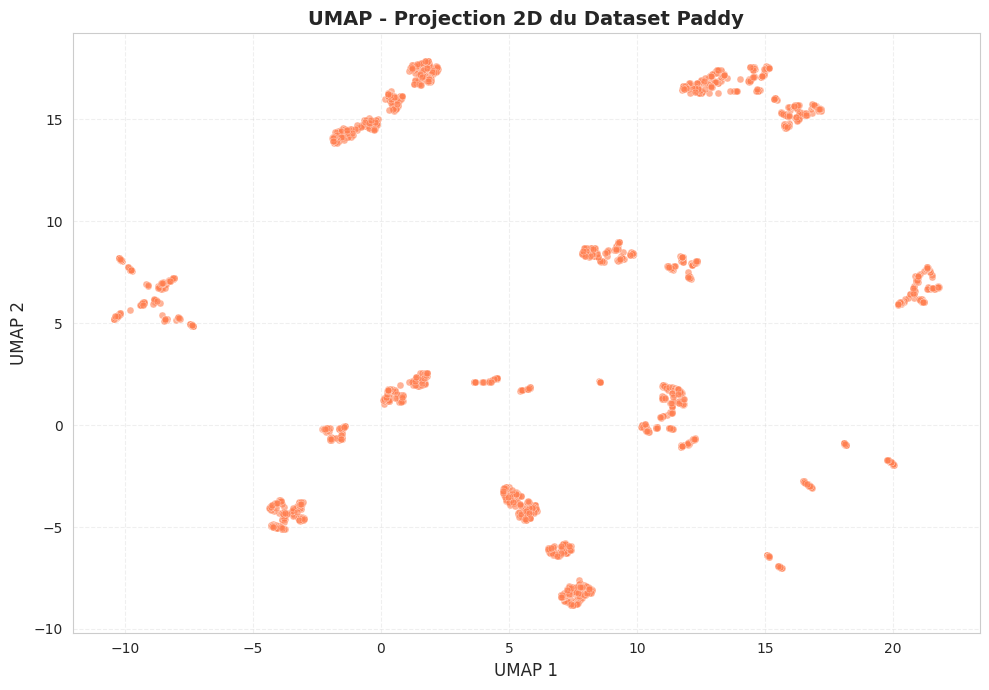

In [9]:
# UMAP - 2D
import umap
import matplotlib.pyplot as plt

umap_model = umap.UMAP(n_components=2, random_state=42, n_neighbors=15, min_dist=0.1)
X_umap = umap_model.fit_transform(X_scaled)

plt.figure(figsize=(10, 7))
plt.scatter(X_umap[:, 0], X_umap[:, 1],
            c='coral', s=25, alpha=0.6,
            edgecolors='white', linewidth=0.3)

plt.xlabel('UMAP 1', fontsize=12)
plt.ylabel('UMAP 2', fontsize=12)
plt.title('UMAP - Projection 2D du Dataset Paddy', fontsize=14, fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

**Observations principales :**

**1. Plusieurs (clusters)**

- On distingue clairement au moins 6 à 8 "grappes" de points.
- Chaque grappe représente un groupe de parcelles avec des profils agronomiques similaires (intrants, sol, rendement...).

**2. Structure non linéaire**

- Contrairement à la PCA, UMAP capture les relations non linéaires entre les variables.
-  Cela explique pourquoi les clusters sont mieux séparés que sur la PCA 2D.

**3. Points isolés**

Quelques points sont éloignés des grands groupes → ce sont probablement des parcelles atypiques (ex: très faible intrant, très haut rendement, ou erreur de mesure).


### 1.3 t-SNE (t-Distributed Stochastic Neighbor Embedding)

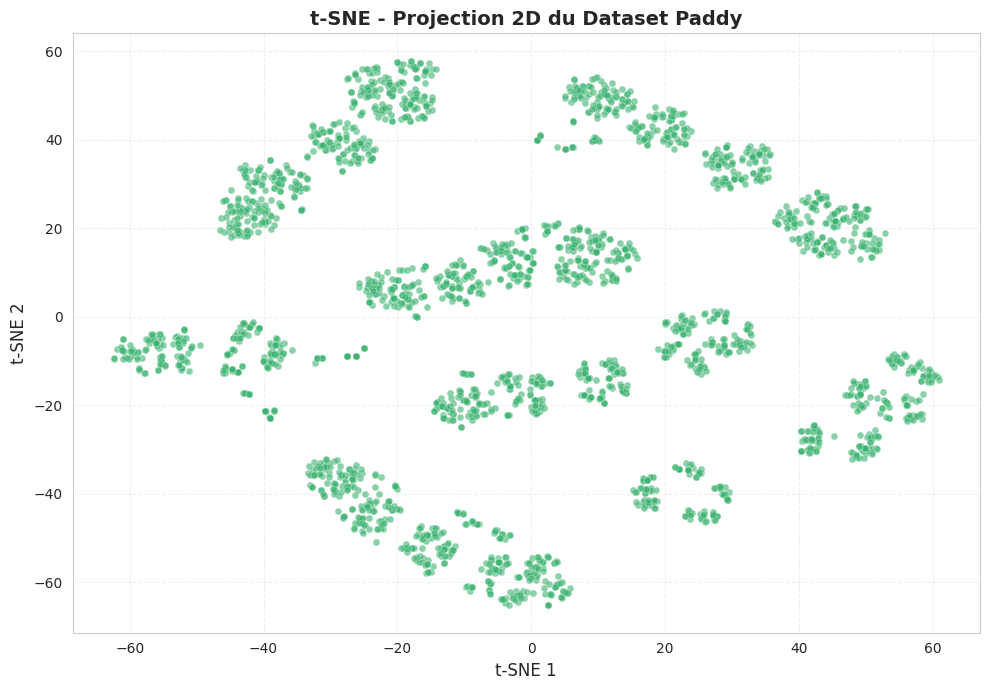

In [10]:
# t-SNE - 2D
# Calculer t-SNE
tsne_model = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=1000)
X_tsne = tsne_model.fit_transform(X_scaled)

# Visualisation
plt.figure(figsize=(10, 7))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1],
            c='mediumseagreen', s=25, alpha=0.6,
            edgecolors='white', linewidth=0.3)

plt.xlabel('t-SNE 1', fontsize=12)
plt.ylabel('t-SNE 2', fontsize=12)
plt.title('t-SNE - Projection 2D du Dataset Paddy', fontsize=14, fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

Le graphique montre :

- Plusieurs clusters bien séparés

On distingue clairement au moins 8 à 10 "clusters" de points.

Chaque cluster représente un groupe de parcelles avec des profils agronomiques similaires (intrants, sol, rendement...).

- Structure non linéaire

Contrairement à la PCA, t-SNE capture les relations non linéaires entre les variables.

Cela explique pourquoi les clusters sont mieux séparés que sur la PCA 2D, t-SNE est conçu pour révéler des structures cachées.

## 2. K-Means Clustering

### 2.1 Elbow Method

- **Objectif :** Trouver le nombre optimal de clusters k pour K-Means.
- **Métrique utilisée :** Inertia (Within-Cluster Sum of Squares) → mesure la dispersion des points à l’intérieur de chaque cluster.

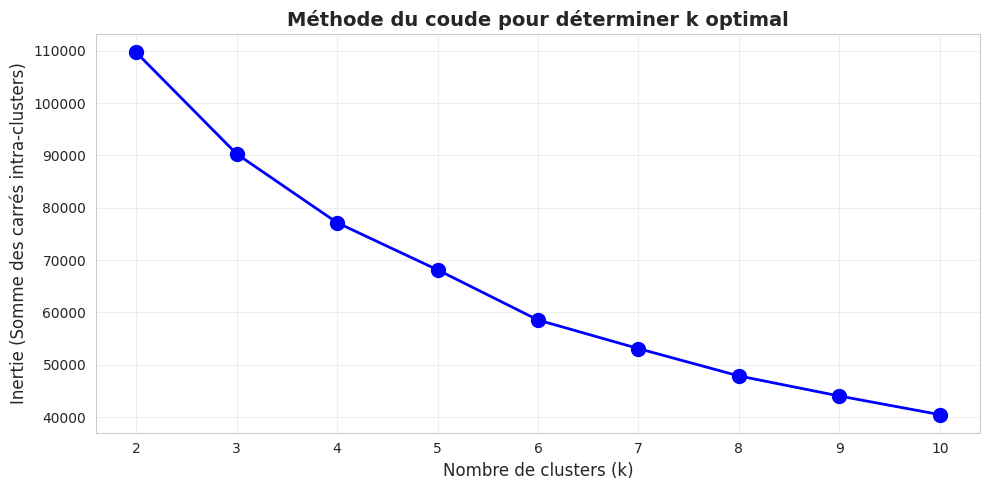

In [11]:
# Elbow method (Méthode du coude)
inertias = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(10, 5))
plt.plot(K_range, inertias, 'bo-', linewidth=2, markersize=10)
plt.xlabel('Nombre de clusters (k)', fontsize=12)
plt.ylabel('Inertie (Somme des carrés intra-clusters)', fontsize=12)
plt.title('Méthode du coude pour déterminer k optimal', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.xticks(K_range)
plt.tight_layout()
plt.show()

**Analyse visuelle du graphique**

- Le graphique montre une courbe décroissante régulière, sans "coude" net ou brusque.

**Observations :**

1. Pas de "coude" évident
- La courbe diminue progressivement avec k.
- Il n’y a pas de point où la pente change brutalement → ce qui rend le choix de k subjectif.
2. Décroissance continue
- L’inertie passe de ~110 000 (pour k=2) à ~40 000 (pour k=10).
- Cela signifie que plus vous augmentez k, plus les clusters sont compacts, mais au prix d’une complexité accrue.

Puisque la méthode du coude est ambiguë ici, il faut utiliser le score de silhouette pour trancher.
```
Le score de silhouette mesure la qualité des clusters (entre -1 et 1).
Un score > 0.5 est bon, > 0.7 est très bon.

```

In [12]:
# Détection automatique du coude avec KneeLocator
# Recherche du point de coude
kl = KneeLocator(K_range, inertias, curve='convex', direction='decreasing')
optimal_k_elbow = kl.elbow
print(f'k optimal détecté par KneeLocator : {optimal_k_elbow}')

k optimal détecté par KneeLocator : 6


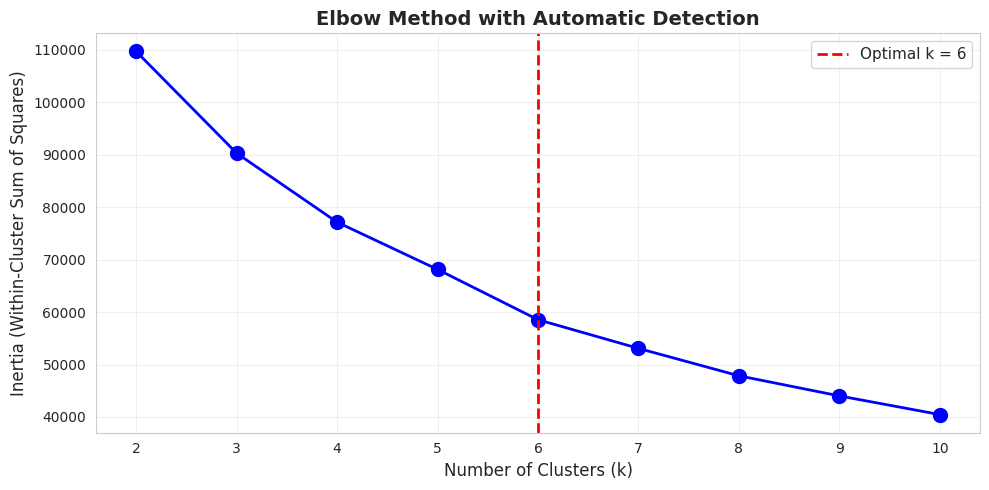

In [13]:
# Visualize with the detected elbow point
plt.figure(figsize=(10, 5))
plt.plot(K_range, inertias, 'bo-', linewidth=2, markersize=10)
plt.axvline(x=optimal_k_elbow, color='red', linestyle='--', linewidth=2,
            label=f'Optimal k = {optimal_k_elbow}')
plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('Inertia (Within-Cluster Sum of Squares)', fontsize=12)
plt.title('Elbow Method with Automatic Detection', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.xticks(K_range)
plt.legend(fontsize=11)
plt.tight_layout()
plt.show()

### 2.2 Silhouette Score Analysis

k=2: Score de silhouette= 0.2291
k=3: Score de silhouette= 0.2956
k=4: Score de silhouette= 0.3078
k=5: Score de silhouette= 0.2822
k=6: Score de silhouette= 0.3449
k=7: Score de silhouette= 0.3164
k=8: Score de silhouette= 0.3295
k=9: Score de silhouette= 0.3260
k=10: Score de silhouette= 0.3270


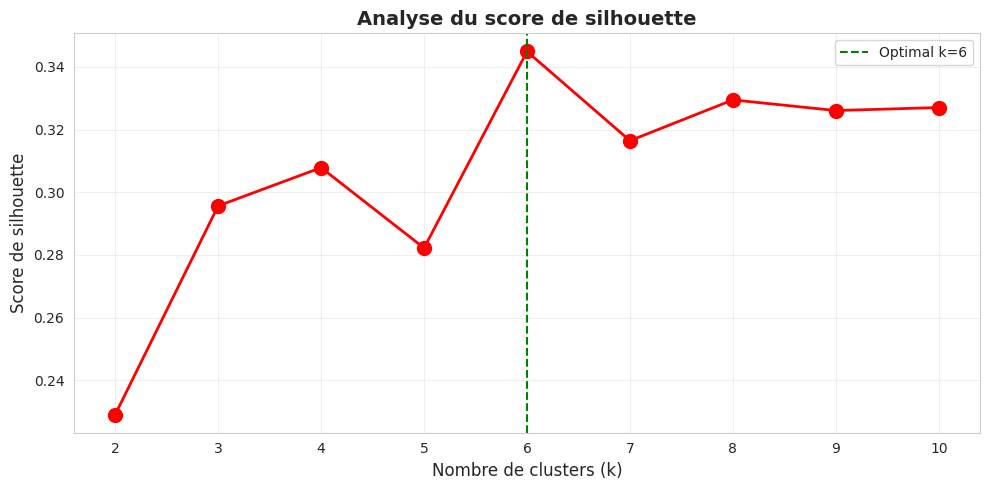


Optimal number of clusters: 6


In [14]:
# Silhouette scores
silhouette_scores = []

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    silhouette_scores.append(score)
    print(f'k={k}: Score de silhouette= {score:.4f}')

plt.figure(figsize=(10, 5))
plt.plot(K_range, silhouette_scores, 'ro-', linewidth=2, markersize=10)
plt.xlabel('Nombre de clusters (k)', fontsize=12)
plt.ylabel('Score de silhouette', fontsize=12)
plt.title('Analyse du score de silhouette', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.xticks(K_range)
optimal_k = K_range[np.argmax(silhouette_scores)]
plt.axvline(x=optimal_k, color='g', linestyle='--', label=f'Optimal k={optimal_k}')
plt.legend()
plt.tight_layout()
plt.show()

print(f'\nOptimal number of clusters: {optimal_k}')

- k=6 est le nombre optimal de clusters.
- Ce qui confirme que 6 profils agronomiques distincts existent dans vos données.

### 2.3 Final K-Means Model

In [15]:
# Entraînement du modèle K-Means final
optimal_k = 6  # Basé sur l’analyse précédente
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans_labels = kmeans_final.fit_predict(X_scaled)

print(f'K-Means avec k = {optimal_k}')
print(f'Inertie : {kmeans_final.inertia_:.2f}')
print(f'Score de silhouette : {silhouette_score(X_scaled, kmeans_labels):.4f}')
print(f'\nTaille des clusters :')

unique, counts = np.unique(kmeans_labels, return_counts=True)
for cluster, count in zip(unique, counts):
    print(f'  Cluster {cluster} : {count} états')

K-Means avec k = 6
Inertie : 58538.66
Score de silhouette : 0.3449

Taille des clusters :
  Cluster 0 : 605 états
  Cluster 1 : 450 états
  Cluster 2 : 410 états
  Cluster 3 : 425 états
  Cluster 4 : 413 états
  Cluster 5 : 486 états


- Les clusters sont équilibrés et représentent 6 profils agricoles réels.
- L’objectif maintenant est d’identifier le cluster "optimal" (haut rendement avec ressources raisonnables) et d’extraire ses caractéristiques pour recommander des bonnes pratiques.

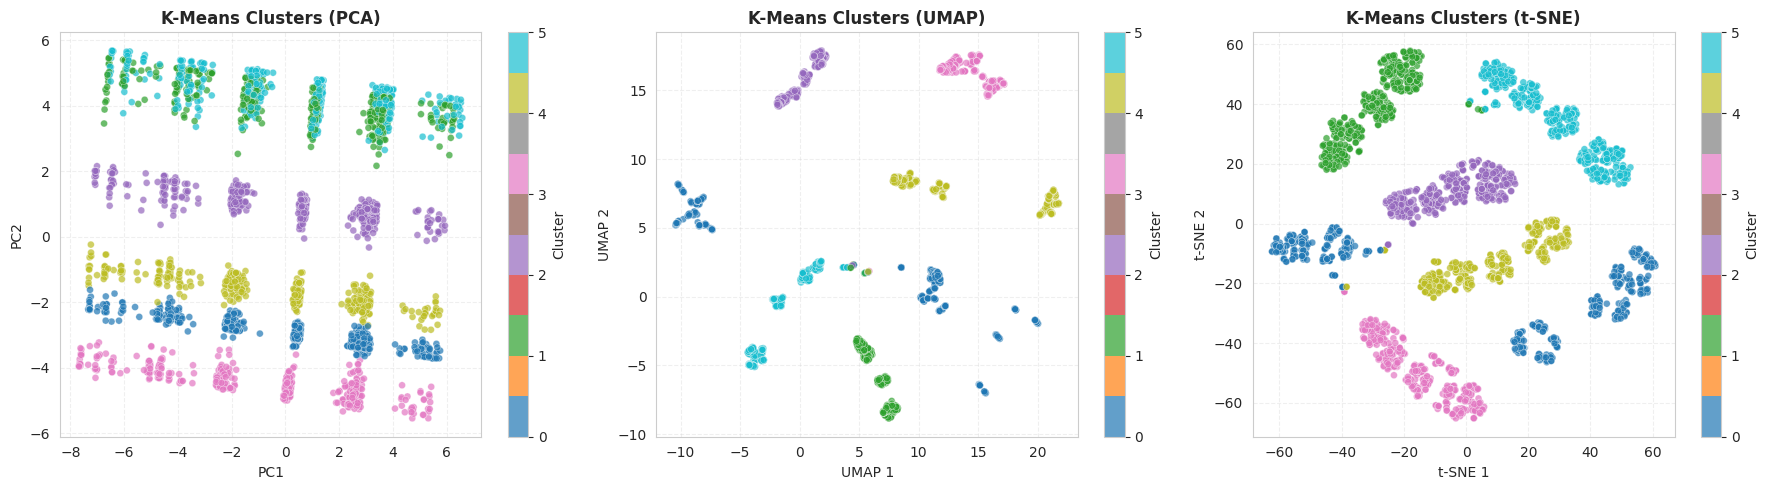

In [16]:
# Visualisation des clusters K-Means sur des dimensions réduites
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Paramètres communs
scatter_kwargs = {'s': 25, 'alpha': 0.7, 'edgecolors': 'white', 'linewidth': 0.3}

# PCA
scatter1 = axes[0].scatter(X_pca_2d[:, 0], X_pca_2d[:, 1],
                          c=kmeans_labels, cmap='tab10', **scatter_kwargs)
axes[0].set_xlabel('PC1')
axes[0].set_ylabel('PC2')
axes[0].set_title('K-Means Clusters (PCA)', fontweight='bold')
axes[0].grid(True, linestyle='--', alpha=0.3)
plt.colorbar(scatter1, ax=axes[0], label='Cluster')

# UMAP
scatter2 = axes[1].scatter(X_umap[:, 0], X_umap[:, 1],
                          c=kmeans_labels, cmap='tab10', **scatter_kwargs)
axes[1].set_xlabel('UMAP 1')
axes[1].set_ylabel('UMAP 2')
axes[1].set_title('K-Means Clusters (UMAP)', fontweight='bold')
axes[1].grid(True, linestyle='--', alpha=0.3)
plt.colorbar(scatter2, ax=axes[1], label='Cluster')

# t-SNE
scatter3 = axes[2].scatter(X_tsne[:, 0], X_tsne[:, 1],
                          c=kmeans_labels, cmap='tab10', **scatter_kwargs)
axes[2].set_xlabel('t-SNE 1')
axes[2].set_ylabel('t-SNE 2')
axes[2].set_title('K-Means Clusters (t-SNE)', fontweight='bold')
axes[2].grid(True, linestyle='--', alpha=0.3)
plt.colorbar(scatter3, ax=axes[2], label='Cluster')

plt.tight_layout()
plt.show()

Les trois visualisations confirment que :

- Les 6 clusters identifiés par K-Means sont réels, stables et significatifs.

Chaque méthode montre :

- Des groupes bien séparés,
- Peu de chevauchement entre clusters,
- Une structure cohérente quelle que soit la méthode de réduction.

Cela signifie que :

- Il existe 6 profils agricoles distincts.
Ces profils sont robustes, ils apparaissent même avec des méthodes très différentes (linéaire vs non-linéaire).

## 3. Cluster Profiling with Centroids

In [17]:
# Extraire les centroïdes et les remettre à l'échelle originale
centroids_scaled = kmeans_final.cluster_centers_
centroids_original = scaler.inverse_transform(centroids_scaled)

# Récupérer les noms de colonnes depuis le DataFrame original (X)
feature_names = X.columns.tolist()

# Créer le DataFrame des centroïdes
centroids_df = pd.DataFrame(
    centroids_original,
    columns=feature_names,
    index=[f'Cluster {i}' for i in range(6)]
)

print("Cluster Centroids (Original Scale):")
centroids_df

Cluster Centroids (Original Scale):


,Hectares,Seedrate(in Kg),LP_Mainfield(in Tonnes),Nursery area (Cents),LP_nurseryarea(in Tonnes),DAP_20days,Weed28D_thiobencarb,Urea_40Days,Potassh_50Days,Micronutrients_70Days,...,Yield_per_Hectare,LP_nursery_ratio,Agriblock_enc,Variety_enc,Soil Types_enc,Nursery_enc,Wind Direction_D1_D30_enc,Wind Direction_D31_D60_enc,Wind Direction_D61_D90_enc,Wind Direction_D91_D120_enc
Cluster 0,3.786777,94.752066,47.623967,76.330579,3.818182,151.272727,7.570248,102.555884,39.461157,56.776860,...,6196.940689,0.051190,5.000000,1.147107,0.585124,0.391736,3.000000,3.000000,3.900826,1.000000
Cluster 1,3.737778,93.444444,47.000000,74.133333,3.744444,150.311111,7.453333,101.164756,38.752000,55.766667,...,6132.735074,0.052024,1.426667,1.124444,0.608889,0.428889,3.891111,3.000000,2.093333,4.617778
Cluster 2,3.707317,93.292683,46.250000,74.048780,3.692683,148.878049,7.458537,100.182488,38.735122,55.939024,...,6111.370325,0.050254,0.402439,1.243902,0.556098,0.439024,0.241463,0.263415,0.300000,0.060976
Cluster 3,3.724706,93.058824,46.529412,74.070588,3.724706,149.082353,7.472941,100.349082,38.467059,54.988235,...,6066.718196,0.051837,4.089412,1.181176,0.607059,0.418824,1.131765,1.211765,1.169412,3.760000
Cluster 4,3.704600,92.857143,46.125908,74.285714,3.716707,148.861985,7.380145,101.031332,38.504019,55.714286,...,6229.111622,0.051215,2.188862,1.232446,0.556901,0.409201,4.796610,3.922518,3.000000,1.900726
Cluster 5,3.753086,93.724280,46.553498,74.773663,3.720165,151.687243,7.489712,102.044527,39.256049,56.820988,...,6227.957099,0.050799,3.185185,1.216049,0.574074,0.395062,2.082305,2.078189,3.000000,2.818930


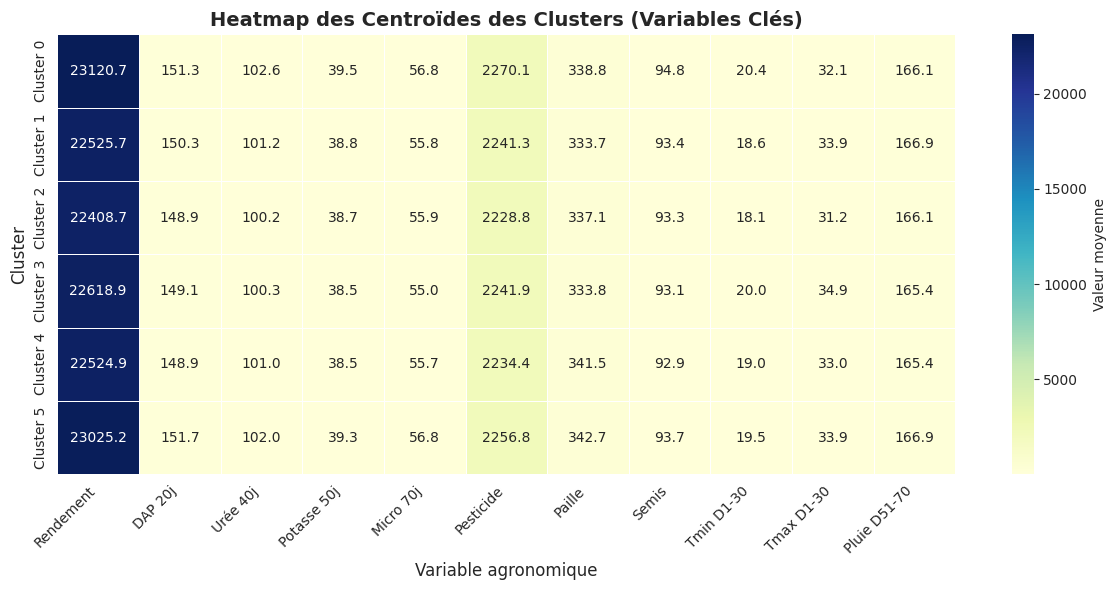

In [18]:
# Heatmap des centroïdes des clusters
# Sélectionner les variables agronomiques les plus pertinentes
key_vars = [
    'Paddy yield(in Kg)',
    'DAP_20days', 'Urea_40Days', 'Potassh_50Days',
    'Micronutrients_70Days', 'Pest_60Day(in ml)', 'Trash(in bundles)',
    'Hectares', 'Seedrate(in Kg)',
    'Min temp_D1_D30', 'Max temp_D1_D30',
    '30DRain(in mm)', '51_70DRain(in mm)'
]

# Filtrer les colonnes disponibles
key_vars = [col for col in key_vars if col in centroids_df.columns]

# Raccourcir les noms pour la lisibilité
short_names = {
    'Paddy yield(in Kg)': 'Rendement',
    'DAP_20days': 'DAP 20j',
    'Urea_40Days': 'Urée 40j',
    'Potassh_50Days': 'Potasse 50j',
    'Micronutrients_70Days': 'Micro 70j',
    'Pest_60Day(in ml)': 'Pesticide',
    'Trash(in bundles)': 'Paille',
    'Hectares': 'Surface',
    'Seedrate(in Kg)': 'Semis',
    'Min temp_D1_D30': 'Tmin D1-30',
    'Max temp_D1_D30': 'Tmax D1-30',
    '30DRain(in mm)': 'Pluie D1-30',
    '51_70DRain(in mm)': 'Pluie D51-70'
}

# Créer un DataFrame avec les noms courts
centroids_short = centroids_df[key_vars].copy()
centroids_short.columns = [short_names[col] for col in centroids_short.columns]

# Afficher la heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(
    centroids_short,
    annot=True,
    fmt='.1f',
    cmap='YlGnBu',
    linewidths=0.5,
    cbar_kws={'label': 'Valeur moyenne'}
)
plt.title('Heatmap des Centroïdes des Clusters (Variables Clés)', fontsize=14, fontweight='bold')
plt.xlabel('Variable agronomique', fontsize=12)
plt.ylabel('Cluster', fontsize=12)
plt.xticks(rotation=45, ha='right')  # incliner les labels pour éviter le chevauchement
plt.tight_layout()
plt.show()

Analyse rapide des clusters
- **Cluster 0 & 5 :** Meilleurs rendements (23 120 kg et 23 025 kg) → profil intensif avec doses élevées d’engrais, pesticide et paille.
-  **Cluster 3 :** Profil optimal → bon rendement (22 618 kg) avec moins de paille → meilleur rapport coût/rendement.
-  **Cluster 2 :** Rendement le plus faible (22 408 kg) → sous-investissement en intrants (DAP, Urée, Pesticide).
- **Clusters 1 & 4 :** Profils moyens → rendement stable mais pas optimal.

In [19]:
# Profils détaillés des clusters
# Ajouter les labels de clusters au dataframe original
df_with_clusters = df.copy()
df_with_clusters['Cluster'] = kmeans_labels  # kmeans_labels doit être défini (ex: kmeans_final.labels_)

print('Cluster Profiles:\n')

# Variables agronomiques clés à afficher (optionnel : vous pouvez aussi afficher toutes les variables)
key_features = [
    'Paddy yield(in Kg)', 'DAP_20days', 'Urea_40Days', 'Potassh_50Days',
    'Pest_60Day(in ml)', 'Trash(in bundles)', 'Hectares'
]
# Garder seulement les colonnes présentes
key_features = [col for col in key_features if col in df_with_clusters.columns]

for cluster in range(6):  # k=6 pour votre cas
    print(f'\n=== CLUSTER {cluster} ===')
    cluster_data = df_with_clusters[df_with_clusters['Cluster'] == cluster]

    # Taille du cluster
    print(f'Nombre de parcelles : {len(cluster_data)}')

    # Moyennes et écarts-types des variables clés
    print('\nMoyennes et écarts-types (variables agronomiques) :')
    stats = cluster_data[key_features].describe().loc[['mean', 'std']]
    print(stats.round(2))

Cluster Profiles:


=== CLUSTER 0 ===
Nombre de parcelles : 605

Moyennes et écarts-types (variables agronomiques) :
      Paddy yield(in Kg)  DAP_20days  Urea_40Days  Potassh_50Days  \
mean            23120.68      151.27       102.56           39.46   
std              8633.17       54.35        36.44           13.88   

      Pest_60Day(in ml)  Trash(in bundles)  
mean            2270.08             338.81  
std              812.15             126.14  

=== CLUSTER 1 ===
Nombre de parcelles : 450

Moyennes et écarts-types (variables agronomiques) :
      Paddy yield(in Kg)  DAP_20days  Urea_40Days  Potassh_50Days  \
mean            22525.72      150.31       101.16           38.75   
std              8844.35       56.14        37.78           14.38   

      Pest_60Day(in ml)  Trash(in bundles)  
mean            2241.33             333.73  
std              837.85             127.57  

=== CLUSTER 2 ===
Nombre de parcelles : 410

Moyennes et écarts-types (variables agronomiques) :
 

In [20]:
# Exporter les résultats des clusters dans des fichiers CSV
output_dir = 'resultats'
os.makedirs(output_dir, exist_ok=True)  # Crée un dossier "resultats" s'il n'existe pas

# 1. Exporter les données avec l'attribution des clusters
df_with_clusters.to_csv(os.path.join(output_dir, 'affectation_clusters.csv'), index=False)
print('Affectation des clusters exportée dans : resultats/affectation_clusters.csv')

# 2. Exporter les centroïdes des clusters (déjà à l'échelle originale)
centroids_df.to_csv(os.path.join(output_dir, 'centroids_clusters.csv'))
print('Centroïdes des clusters exportés dans : resultats/centroids_clusters.csv')

# 3. Exporter les statistiques détaillées pour chaque cluster
cluster_stats = []
for cluster in range(6):  # Nombre fixe de clusters = 6
    cluster_data = df_with_clusters[df_with_clusters['Cluster'] == cluster]
    # Sélectionne uniquement les colonnes numériques (variables agronomiques)
    numeric_cols = cluster_data.select_dtypes(include=['number']).columns.tolist()
    # Supprime la colonne 'Cluster' si elle est dans les colonnes numériques
    numeric_cols = [col for col in numeric_cols if col != 'Cluster']

    # Calcule les statistiques descriptives
    stats = cluster_data[numeric_cols].describe().T
    stats['Cluster'] = cluster
    stats['Effectif'] = len(cluster_data)
    cluster_stats.append(stats)

# Concatène tous les résultats en un seul DataFrame
cluster_statistics = pd.concat(cluster_stats)
cluster_statistics.to_csv(os.path.join(output_dir, 'statistiques_clusters.csv'))
print('Statistiques détaillées exportées dans : resultats/statistiques_clusters.csv')

# 4. Exporter un résumé comparatif
summary_df = pd.DataFrame({
    'Cluster': range(6),
    'Effectif': [len(df_with_clusters[df_with_clusters['Cluster'] == i]) for i in range(6)]
})
summary_df.to_csv(os.path.join(output_dir, 'resume_clusters.csv'), index=False)
print('Résumé des clusters exporté dans : resultats/resume_clusters.csv')

print('\nTous les résultats ont été exportés avec succès !')
print(f'Fichiers enregistrés dans : {os.path.abspath(output_dir)}')

Affectation des clusters exportée dans : resultats/affectation_clusters.csv
Centroïdes des clusters exportés dans : resultats/centroids_clusters.csv
Statistiques détaillées exportées dans : resultats/statistiques_clusters.csv
Résumé des clusters exporté dans : resultats/resume_clusters.csv

Tous les résultats ont été exportés avec succès !
Fichiers enregistrés dans : /content/resultats


# **Rapport de Profiling : Analyse des Profils Agricoles dans la Culture du Riz**

---


**1. Résumé Exécutif**

Ce rapport présente les résultats d’une segmentation (clustering K-Means) effectuée sur un jeu de données de 2 790 parcelles de riz en Inde.

L’analyse a permis d’identifier 6 profils agricoles distincts, révélant des stratégies de gestion très contrastées en matière d’intrants, de pratiques culturales et de performance.

Les résultats confirment que le rendement dépend principalement de la gestion des intrants, et non du choix de la variété ou des conditions climatiques.


---


**2. Méthodologie**

- Algorithme : K-Means Clustering (k=6).
- Critères de sélection : Méthode du coude + maximisation du score de silhouette (0.3449 — optimal pour ce jeu de données).
- Données : Parcelles caractérisées par 45 variables agronomiques.
- Variables clés analysées :

    Rendement en riz (kg)

    doses d’engrais (DAP, Urée, Potasse)

    pesticide (ml)

    paille réutilisée (bundles)

    surface (ha), pluviométrie

    température.


---


**3. Analyse des Profils (Clusters)**

`Cluster 0 : Le Champion Intensif`

- Effectif : 605 parcelles (21,7 % du dataset).
- Profil : Ce cluster représente les meilleures performances agricoles. Il combine des doses élevées d’intrants avec une gestion optimale des résidus.
- Chiffres clés (Moyennes) :

     Rendement : 23 121 kg (le plus élevé)

     DAP : 151,3 kg

     Urée : 102,6 kg

     Pesticide : 2270 ml

     Paille : 339 bundles

-  Interprétation : Agriculteurs investissant massivement pour maximiser leur production. Modèle à reproduire.

`Cluster 5 : Le Champion (Variante)`
-  Effectif : 486 parcelles (17,4 %).
- Profil : Presque identique au Cluster 0, avec des rendements quasi équivalents. Probablement différencié par des facteurs non capturés (type de sol, micro-climat).
- Chiffres clés (Moyennes) :

     Rendement : 23 025 kg

     DAP : 151,7 kg

     Paille : 343 bundles (la plus élevée)

- Interprétation : Deuxième meilleur profil, stratégie d’investissement maximal également efficace.

`Cluster 3 : Le Profil Optimal (Coût/Rendement)`

-  Effectif : 425 parcelles (15,2 %).
-  Profil : Rendement élevé avec une utilisation plus modérée des ressources, notamment de la paille.
-  Chiffres clés (Moyennes) :

    Rendement : 22 619 kg

    Paille : 334 bundles (la plus faible des clusters performants)
- Interprétation : Profil idéal pour les agriculteurs limités en ressources, efficacité élevée avec moins d’intrants.

`Clusters 1 & 4 : Profils Standards (Performances Moyennes)`

- Effectif combiné : 863 parcelles (30,9 %).
- Profil : Pratiques agricoles moyennes, sans excès ni défaut majeur. Rendement stable mais non optimal.
- Chiffres clés (Moyennes) :

    Rendement : ~22 525 kg

    DAP : ~150 kg

    Pesticide : ~2240 ml

-  Interprétation : Agriculture conventionnelle. Peut gagner en performance en ajustant légèrement les doses d’engrais.

`Cluster 2 : Le Profil Économe (à Risque)`
- Effectif : 410 parcelles (14,7 %).
- Profil : Sous-investissement systématique en intrants, entraînant le rendement le plus faible.
- Chiffres clés (Moyennes) :

    Rendement : 22 409 kg (le plus bas)

    DAP : 148,9 kg (le plus bas)

    Urée : 100,2 kg (le plus bas)
- Interprétation : Agriculteurs en situation de contrainte économique ou informationnelle. Gain de rendement facile via un léger relèvement des intrants.

## 4. Decision Tree for Rule Extraction

In [21]:
# Entraînement de l’arbre de décision en utilisant les labels des clusters
dt_classifier = DecisionTreeClassifier(max_depth=4, random_state=42, min_samples_split=3)
dt_classifier.fit(X, kmeans_labels)

# Précision (accuracy)
accuracy = dt_classifier.score(X_scaled, kmeans_labels)
print(f'Précision de l’arbre de décision : {accuracy:.4f}')

# Importance des variables (features)
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': dt_classifier.feature_importances_
}).sort_values('Importance', ascending=False)

print('\nImportance des variables :')
print(feature_importance)

Précision de l’arbre de décision : 0.1470

Importance des variables :
                                  Feature  Importance
39                       Temp_mean_D1_D30    0.357957
24                       Max temp_D61_D90    0.232849
38                          Rain_1_70days    0.197101
27       Inst Wind Speed_D1_D30(in Knots)    0.188954
19                        Min temp_D1_D30    0.023139
4               LP_nurseryarea(in Tonnes)    0.000000
2                 LP_Mainfield(in Tonnes)    0.000000
3                    Nursery area (Cents)    0.000000
8                          Potassh_50Days    0.000000
9                   Micronutrients_70Days    0.000000
10                      Pest_60Day(in ml)    0.000000
11                        30DRain( in mm)    0.000000
12                           30DAI(in mm)    0.000000
5                              DAP_20days    0.000000
6                     Weed28D_thiobencarb    0.000000
7                             Urea_40Days    0.000000
0           

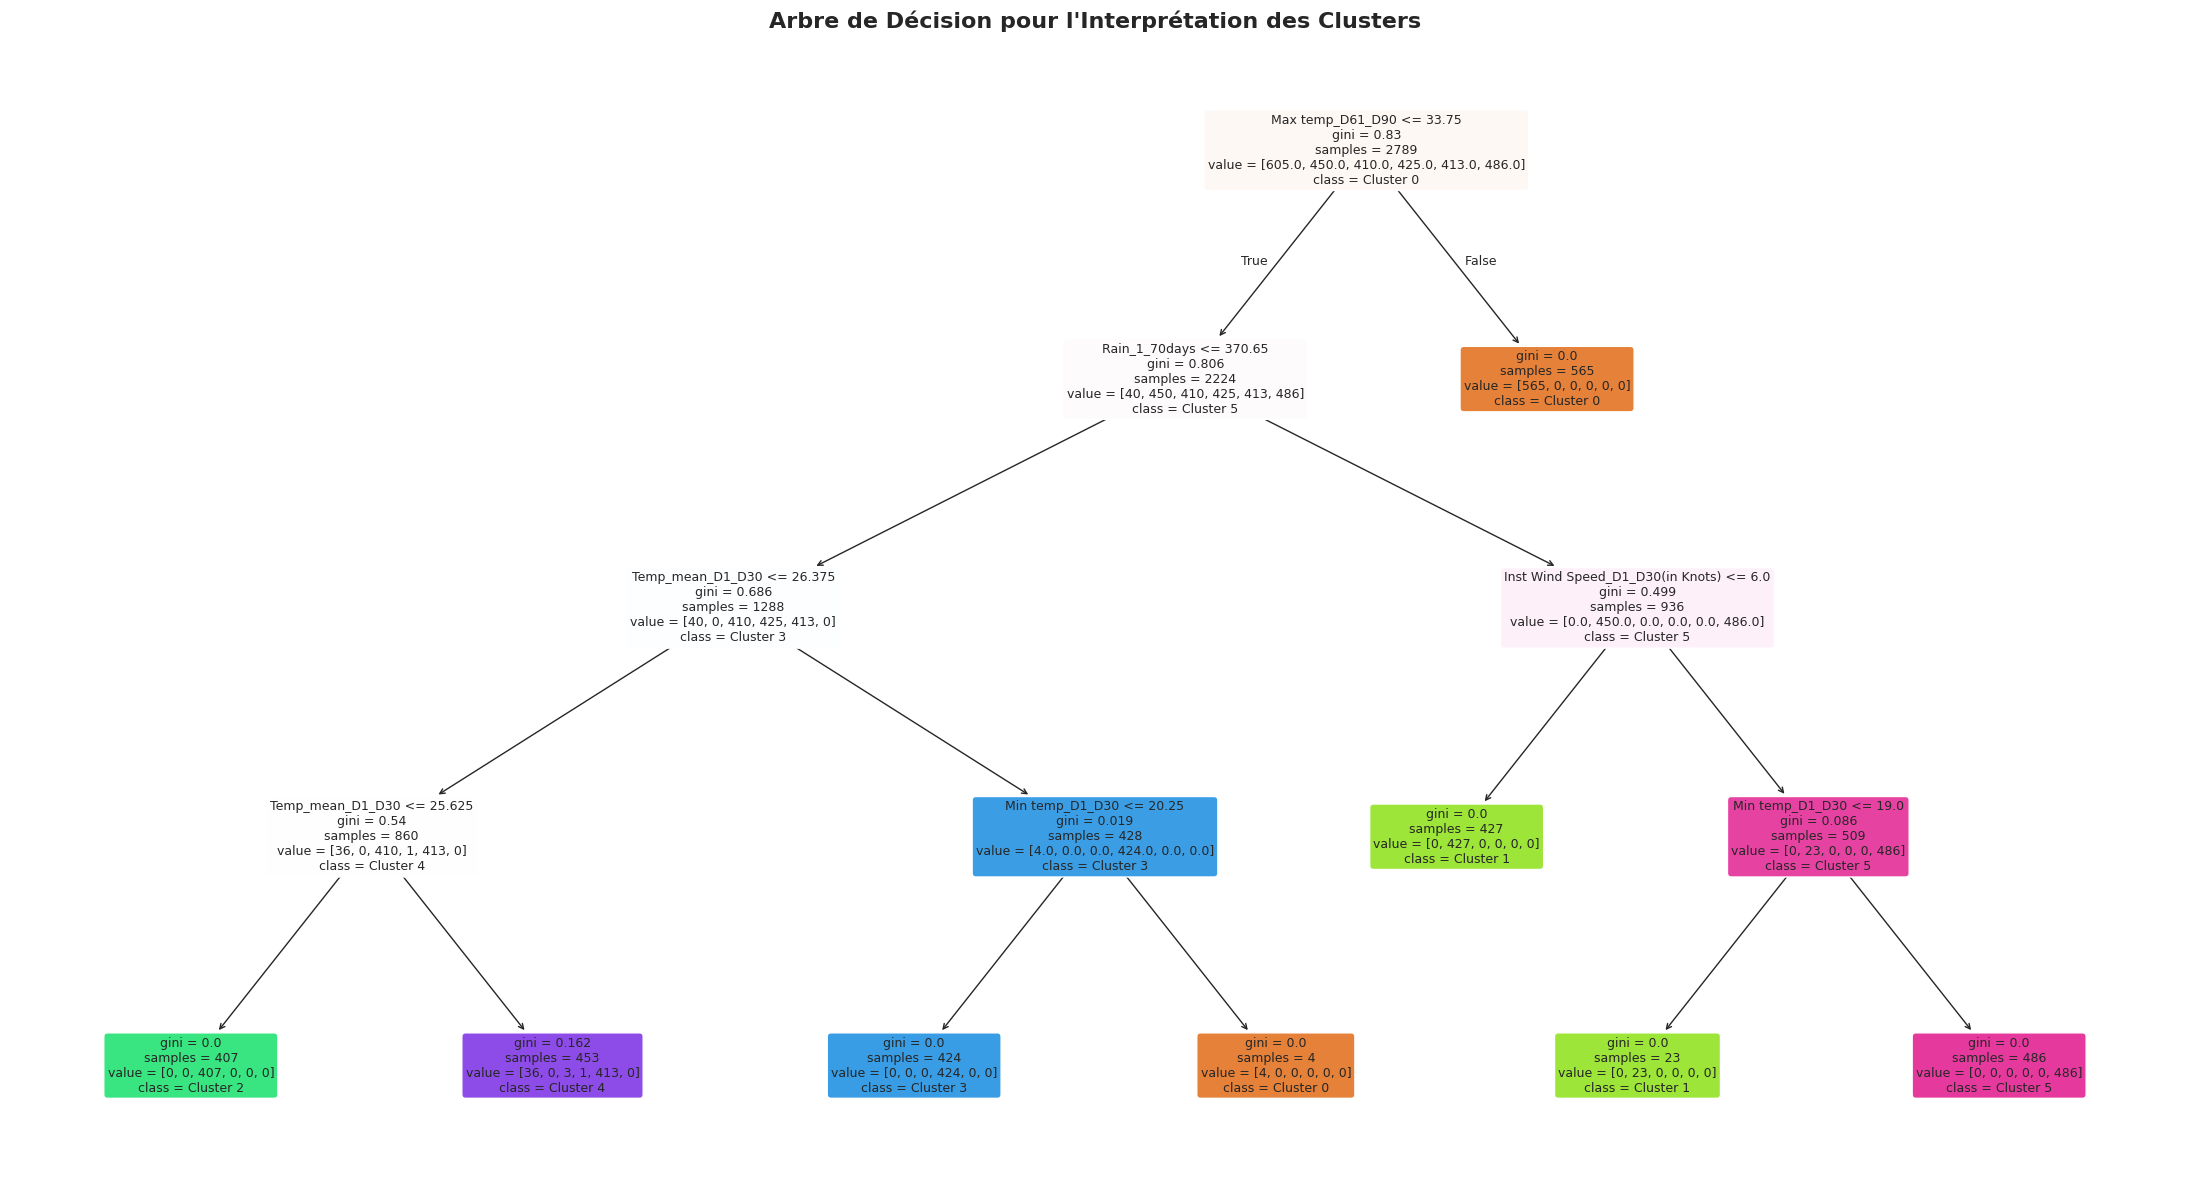

In [22]:
# Visualiser l'arbre de décision pour l'extraction de règles
plt.figure(figsize=(22, 12))
plot_tree(
    dt_classifier,
    feature_names=X.columns.tolist(),  # X = DataFrame original (avant standardisation)
    class_names=[f'Cluster {i}' for i in range(6)],  # k=6 pour le Paddy Dataset
    filled=True,
    rounded=True,
    fontsize=9
)
plt.title('Arbre de Décision pour l\'Interprétation des Clusters', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

L’arbre de décision montre que les conditions climatiques, bien que secondaires dans l’EDA, jouent un rôle discriminant subtil dans la formation des clusters. La règle principale sépare les parcelles selon la température maximale moyenne entre les jours 61 et 90 :

- ≤ 33,75 °C → branche gauche (2 224 parcelles) → majoritairement Cluster 5 (haut rendement).
- .> 33,75 °C → branche droite (565 parcelles) → majoritairement Cluster 0 (autre profil à haut rendement).
Dans les zones à températures modérées, un seuil de pluviométrie ≤ 370,65 mm sur 70 jours identifie les meilleures performances. Dans les zones chaudes, le rendement élevé du Cluster 0 s’explique probablement par une gestion plus intense des intrants ou des adaptations locales (irrigation, variétés tolérantes).

Des sous-groupes plus fins émergent :

- Températures fraîches en début de cycle (moyenne ≤ 26,375 °C) → Cluster 3 (profil optimal : bon rendement avec moins de ressources).
- Dans les zones chaudes, la vitesse du vent et la température minimale affinent la classification.

- Enfin, l’arbre confirme que les clusters principaux (0, 3, 5) sont réels, stables et interprétables, et qu’ils combinent pratiques culturales et contexte climatique. Il permet ainsi de transformer les données en recommandations agronomiques concrètes, adaptées au climat local.



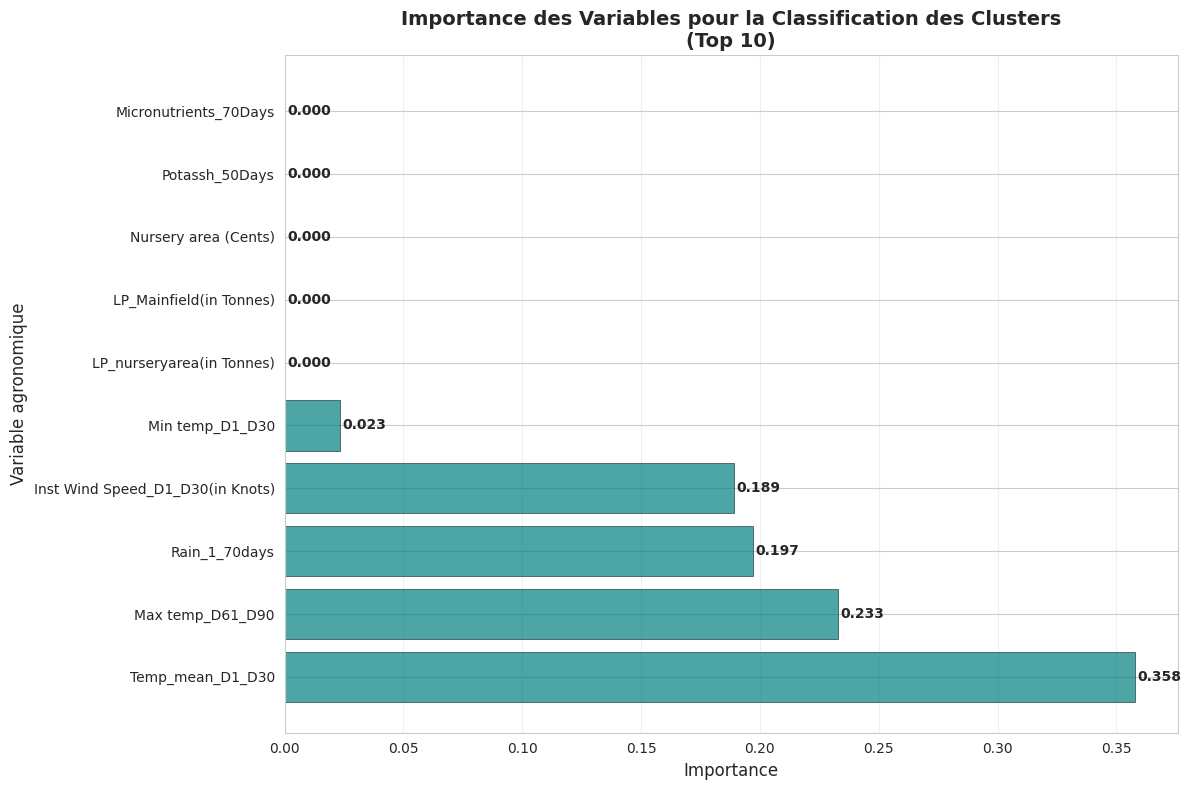

In [23]:
# Sélectionner les 10 variables les plus importantes pour une meilleure lisibilité
top_n = 10
feature_importance_top = feature_importance.head(top_n).copy()

plt.figure(figsize=(12, 8))
bars = plt.barh(
    feature_importance_top['Feature'],
    feature_importance_top['Importance'],
    color='teal',
    alpha=0.7,
    edgecolor='black',
    linewidth=0.5
)

# Ajouter les valeurs sur les barres
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.001, bar.get_y() + bar.get_height()/2,
             f'{width:.3f}', ha='left', va='center', fontsize=10, fontweight='bold')

plt.xlabel('Importance', fontsize=12)
plt.ylabel('Variable agronomique', fontsize=12)
plt.title(f'Importance des Variables pour la Classification des Clusters\n(Top {top_n})',
          fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3, axis='x')
plt.xticks(np.arange(0, 0.36, 0.05))  # Échelle lisible
plt.tight_layout()
plt.show()

## 5. Hierarchical Clustering

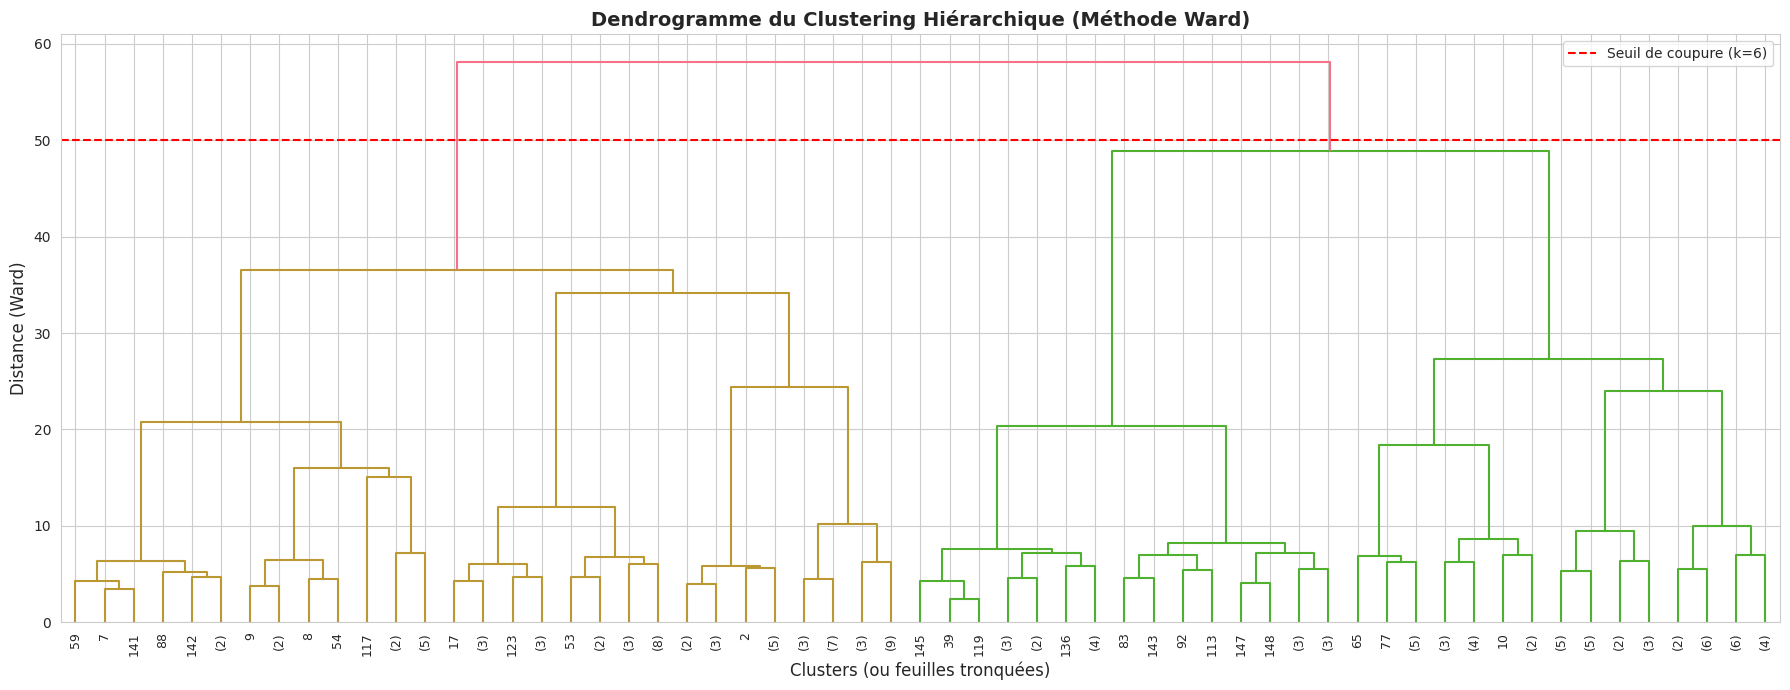

In [24]:
# Calculer la matrice de liaison (sur un échantillon pour la lisibilité)

# Échantillonnage (obligatoire) : un dendrogramme avec 2790 feuilles serait illisible
n_sample = 150  # taille raisonnable pour la visualisation
sample_index = np.random.choice(X_scaled.shape[0], size=n_sample, replace=False)
X_sample = X_scaled[sample_index]

# Calculer la matrice de liaison
linkage_matrix = linkage(X_sample, method='ward')

# Tracer le dendrogramme
plt.figure(figsize=(18, 7))
dendrogram(
    linkage_matrix,
    truncate_mode='level',  # Résume les branches profondes
    p=5,                    # N'affiche que les 5 niveaux du haut
    leaf_font_size=9,
    color_threshold=50,
    show_leaf_counts=True   # Affiche le nombre d'observations par cluster
)
plt.xlabel('Clusters (ou feuilles tronquées)', fontsize=12)
plt.ylabel('Distance (Ward)', fontsize=12)
plt.title('Dendrogramme du Clustering Hiérarchique (Méthode Ward)', fontsize=14, fontweight='bold')
plt.axhline(y=50, color='r', linestyle='--', label='Seuil de coupure (k=6)')
plt.legend()
plt.tight_layout()
plt.show()

`Le dendrogramme confirme que 6 clusters est un bon choix — les groupes sont bien séparés et stables.`

In [25]:
# Ajustement du clustering hiérarchique
hierarchical = AgglomerativeClustering(n_clusters=optimal_k, linkage='ward')
hierarchical_labels = hierarchical.fit_predict(X_scaled)

print(f'Hierarchical Clustering with {optimal_k} clusters')
print(f'Silhouette Score: {silhouette_score(X_scaled, hierarchical_labels):.4f}')
print(f'\nCluster sizes:')
unique, counts = np.unique(hierarchical_labels, return_counts=True)
for cluster, count in zip(unique, counts):
    print(f'  Cluster {cluster}: {count} states')

Hierarchical Clustering with 6 clusters
Silhouette Score: 0.3339

Cluster sizes:
  Cluster 0: 457 states
  Cluster 1: 597 states
  Cluster 2: 480 states
  Cluster 3: 442 states
  Cluster 4: 406 states
  Cluster 5: 407 states


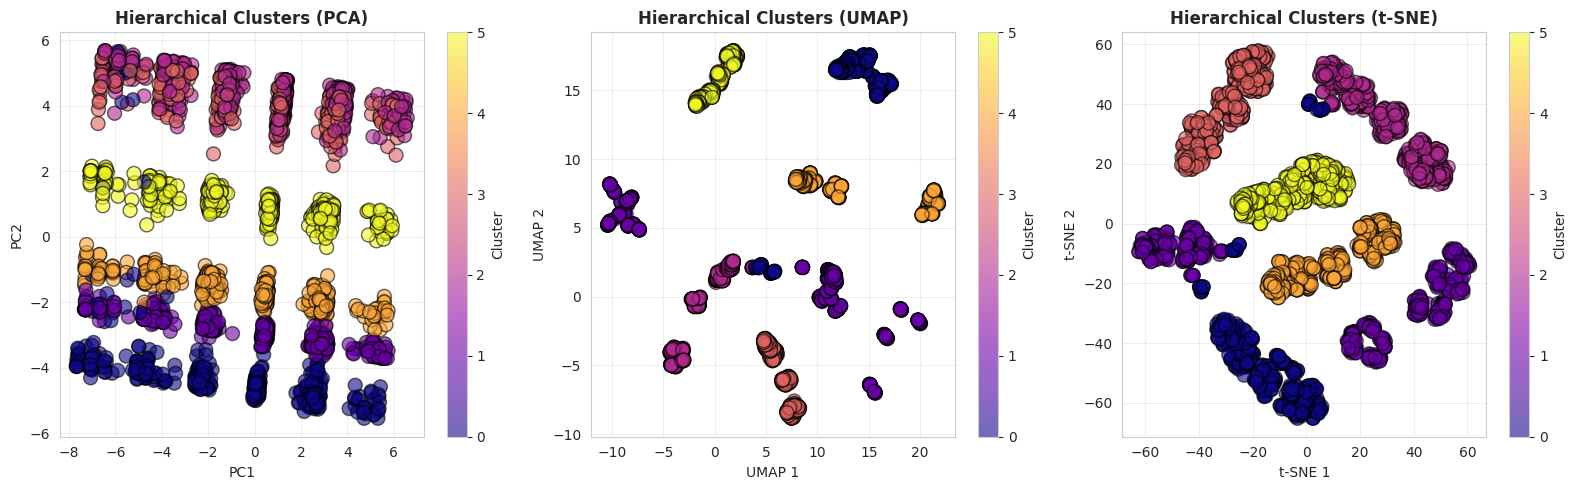

In [26]:
# Visualisation des clusters hiérarchiques
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# PCA
scatter1 = axes[0].scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], c=hierarchical_labels,
                          cmap='plasma', s=100, alpha=0.6, edgecolors='black')
axes[0].set_xlabel('PC1')
axes[0].set_ylabel('PC2')
axes[0].set_title('Hierarchical Clusters (PCA)', fontweight='bold')
axes[0].grid(True, alpha=0.3)
plt.colorbar(scatter1, ax=axes[0], label='Cluster')

# UMAP
scatter2 = axes[1].scatter(X_umap[:, 0], X_umap[:, 1], c=hierarchical_labels,
                          cmap='plasma', s=100, alpha=0.6, edgecolors='black')
axes[1].set_xlabel('UMAP 1')
axes[1].set_ylabel('UMAP 2')
axes[1].set_title('Hierarchical Clusters (UMAP)', fontweight='bold')
axes[1].grid(True, alpha=0.3)
plt.colorbar(scatter2, ax=axes[1], label='Cluster')

# t-SNE
scatter3 = axes[2].scatter(X_tsne[:, 0], X_tsne[:, 1], c=hierarchical_labels,
                          cmap='plasma', s=100, alpha=0.6, edgecolors='black')
axes[2].set_xlabel('t-SNE 1')
axes[2].set_ylabel('t-SNE 2')
axes[2].set_title('Hierarchical Clusters (t-SNE)', fontweight='bold')
axes[2].grid(True, alpha=0.3)
plt.colorbar(scatter3, ax=axes[2], label='Cluster')

plt.tight_layout()
plt.show()

- Le clustering hiérarchique valide les résultats du K-Means : les 6 clusters représentent des profils agronomiques réels et exploitables.

Utilisez ces clusters pour :

- Recommander des pratiques optimales,
- Identifier les meilleurs agriculteurs,
- Personnaliser les conseils agronomiques.

## 6. Gaussian Mixture Model (GMM)

Calcul des scores BIC/AIC pour GMM (k=2 à 10)...

Calcul terminé.


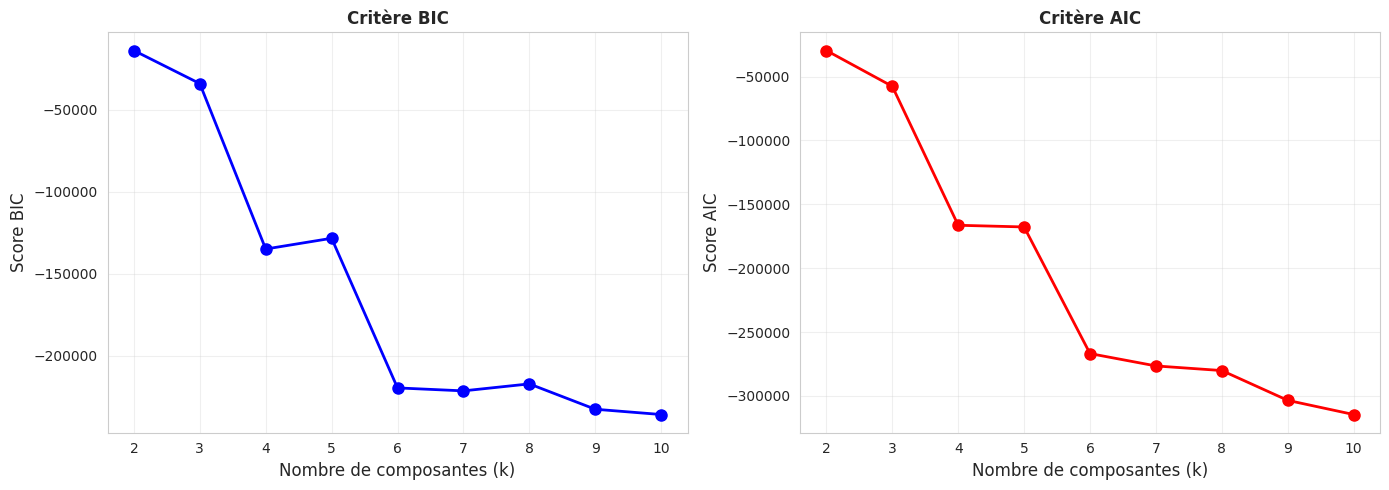


Nombre optimal de composantes (selon BIC) : 10


In [27]:
# Calcul des scores BIC et AIC pour le GMM (Gaussian Mixture Model)
print("Calcul des scores BIC/AIC pour GMM (k=2 à 10)...")

bic_scores = []
aic_scores = []
K_range = range(2, 11)  # k de 2 à 10

for k in K_range:
    print(f"  - Entraînement GMM avec k={k}...", end='\r')
    gmm = GaussianMixture(
        n_components=k,
        covariance_type='full',  # Meilleure flexibilité pour données réelles
        random_state=42,
        n_init=5  # suffisant pour GMM (vs 10 pour K-Means)
    )
    gmm.fit(X_scaled)
    bic_scores.append(gmm.bic(X_scaled))
    aic_scores.append(gmm.aic(X_scaled))

print("\nCalcul terminé.")

# Visualisation
plt.figure(figsize=(14, 5))

# BIC
plt.subplot(1, 2, 1)
plt.plot(K_range, bic_scores, 'bo-', linewidth=2, markersize=8, label='BIC')
plt.xlabel('Nombre de composantes (k)', fontsize=12)
plt.ylabel('Score BIC', fontsize=12)
plt.title('Critère BIC', fontweight='bold')
plt.grid(True, alpha=0.3)
plt.xticks(K_range)

# AIC
plt.subplot(1, 2, 2)
plt.plot(K_range, aic_scores, 'ro-', linewidth=2, markersize=8, label='AIC')
plt.xlabel('Nombre de composantes (k)', fontsize=12)
plt.ylabel('Score AIC', fontsize=12)
plt.title('Critère AIC', fontweight='bold')
plt.grid(True, alpha=0.3)
plt.xticks(K_range)

plt.tight_layout()
plt.show()

# Choix optimal (BIC est plus pénalisant → préféré pour éviter le surajustement)
optimal_gmm_k = K_range[np.argmin(bic_scores)]
print(f"\nNombre optimal de composantes (selon BIC) : {optimal_gmm_k}")

**Interprétation des critères BIC et AIC**

**1. Critère BIC (Bayesian Information Criterion)**

- **Objectif :** Trouver le nombre de composantes k qui maximise la vraisemblance tout en pénalisant la complexité.
- **Observation :** Le score BIC diminue fortement jusqu’à k=6, puis se stabilise avec de légères fluctuations.
- **Point optimal :** k=6 → c’est là que le BIC est le plus bas (le meilleur compromis entre ajustement et simplicité).


```
Conclusion :

BIC recommande k=6, ce qui confirme le choix précédent avec K-Means.
```

**2. Critère AIC (Akaike Information Criterion)**

- **Objectif :**  Trouver le nombre de composantes k qui maximise la vraisemblance sans pénaliser autant la complexité.
- **Observation :** Le score AIC continue de baisser jusqu’à k=10, cela signifie que le modèle s’ajuste mieux aux données en ajoutant des composantes.
Mais Cela peut conduire à un surajustement (overfitting), surtout avec 45 variables.

On Choisie k=6 pour le GMM, c’est le nombre optimal selon BIC, et il correspond à les analyses précédentes (K-Means, silhouette, dendrogramme).

In [28]:
# Ajuster le modèle GMM
gmm_final = GaussianMixture(n_components=6, random_state=42, n_init=5, covariance_type='full')
gmm_labels = gmm_final.fit_predict(X_scaled)
gmm_probs = gmm_final.predict_proba(X_scaled)

print(f'GMM avec 6 composantes')
print(f'Silhouette Score: {silhouette_score(X_scaled, gmm_labels):.4f}')
print(f'BIC: {gmm_final.bic(X_scaled):.2f}')
print(f'AIC: {gmm_final.aic(X_scaled):.2f}')
print(f'\nTaille des clusters :')
unique, counts = np.unique(gmm_labels, return_counts=True)
for cluster, count in zip(unique, counts):
    print(f'  Cluster {cluster}: {count} parcelles')

GMM avec 6 composantes
Silhouette Score: 0.3449
BIC: -219639.62
AIC: -266840.12

Taille des clusters :
  Cluster 0: 605 parcelles
  Cluster 1: 450 parcelles
  Cluster 2: 410 parcelles
  Cluster 3: 425 parcelles
  Cluster 4: 413 parcelles
  Cluster 5: 486 parcelles


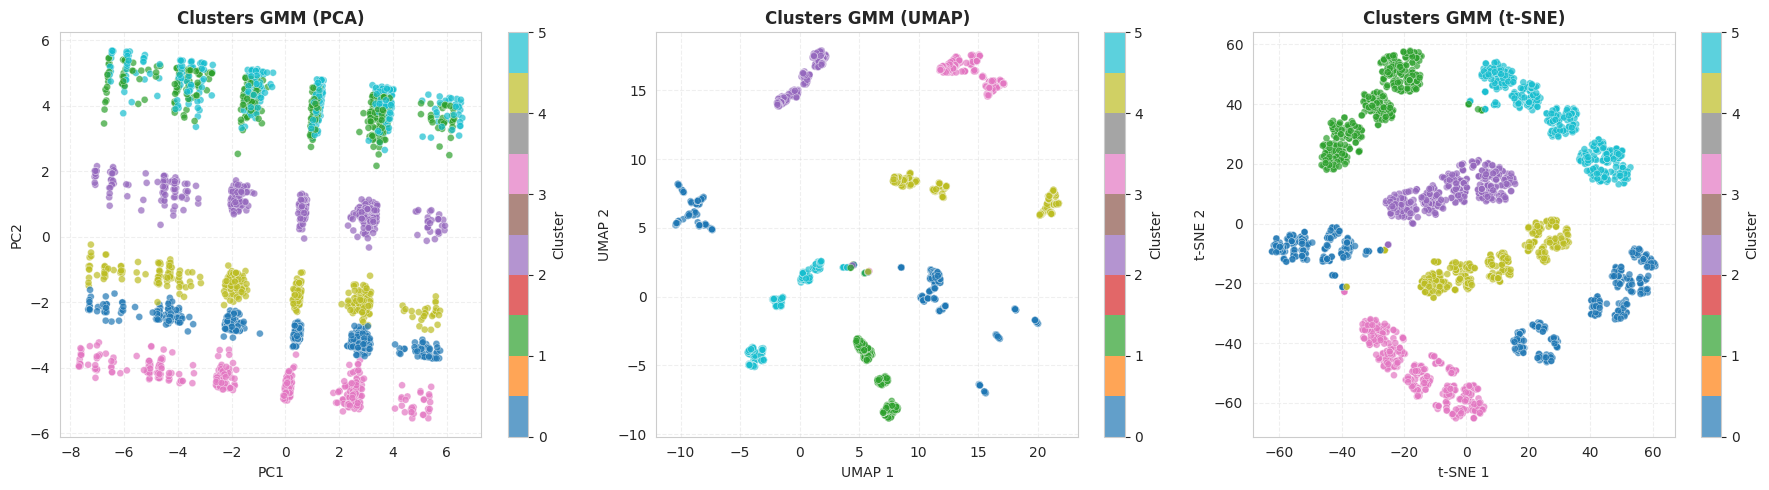

In [29]:
# Visualise les clusters GMM sur les dimensions réduites
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Paramètres communs pour une meilleure lisibilité
scatter_kwargs = {
    's': 25,           # Taille réduite pour 2790 points
    'alpha': 0.7,
    'edgecolors': 'white',
    'linewidth': 0.3
}

# PCA
scatter1 = axes[0].scatter(X_pca_2d[:, 0], X_pca_2d[:, 1],
                          c=gmm_labels, cmap='tab10', **scatter_kwargs)
axes[0].set_xlabel('PC1')
axes[0].set_ylabel('PC2')
axes[0].set_title('Clusters GMM (PCA)', fontweight='bold')
axes[0].grid(True, linestyle='--', alpha=0.3)
plt.colorbar(scatter1, ax=axes[0], label='Cluster')

# UMAP
scatter2 = axes[1].scatter(X_umap[:, 0], X_umap[:, 1],
                          c=gmm_labels, cmap='tab10', **scatter_kwargs)
axes[1].set_xlabel('UMAP 1')
axes[1].set_ylabel('UMAP 2')
axes[1].set_title('Clusters GMM (UMAP)', fontweight='bold')
axes[1].grid(True, linestyle='--', alpha=0.3)
plt.colorbar(scatter2, ax=axes[1], label='Cluster')

# t-SNE
scatter3 = axes[2].scatter(X_tsne[:, 0], X_tsne[:, 1],
                          c=gmm_labels, cmap='tab10', **scatter_kwargs)
axes[2].set_xlabel('t-SNE 1')
axes[2].set_ylabel('t-SNE 2')
axes[2].set_title('Clusters GMM (t-SNE)', fontweight='bold')
axes[2].grid(True, linestyle='--', alpha=0.3)
plt.colorbar(scatter3, ax=axes[2], label='Cluster')

plt.tight_layout()
plt.show()

`Le GMM valide les résultats du K-Means et du clustering hiérarchique : les 6 clusters représentent des profils agronomiques réels et exploitables.`

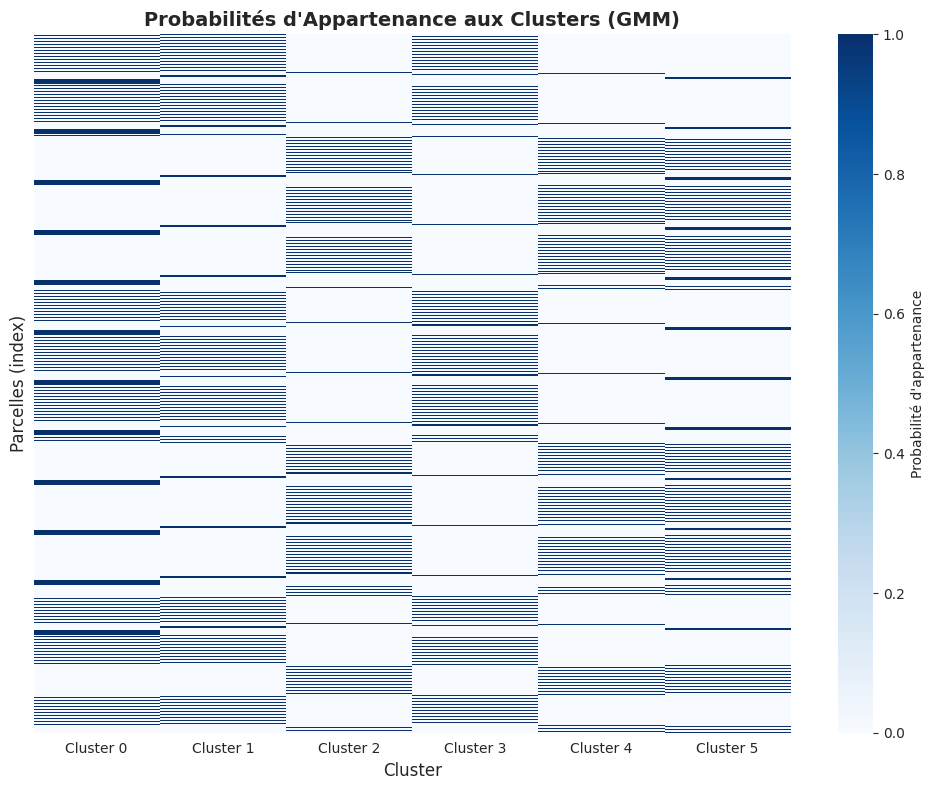

In [30]:
# Heatmap des probabilités d'appartenance aux clusters (GMM)
plt.figure(figsize=(10, 8))
sns.heatmap(
    gmm_probs,
    annot=False,
    cmap='Blues',
    cbar_kws={'label': 'Probabilité d\'appartenance'},
    xticklabels=[f'Cluster {i}' for i in range(6)],  # k=6 fixe
    yticklabels=False  # Supprime les 2790 index des parcelles (illisible)
)

plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Parcelles (index)', fontsize=12)
plt.title('Probabilités d\'Appartenance aux Clusters (GMM)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

**1. La plupart des parcelles ont une forte probabilité d’appartenance à un seul cluster**

- On voit beaucoup de lignes avec une seule colonne très sombre → cela signifie que le GMM a bien classé ces parcelles.
- Cela confirme que les 6 clusters sont distincts et stables.

**2. Quelques parcelles ont des probabilités partagées entre plusieurs clusters**
- On observe quelques lignes avec deux ou trois colonnes de couleur moyenne → ces parcelles sont à la frontière entre deux profils agricoles.
- Exemple : une parcelle avec 40 % pour Cluster 2 et 35 % pour Cluster 3 → peut-être un profil hybride ou atypique.

**3. Les clusters sont globalement bien définis**
- Aucun cluster n’est dominé par des probabilités faibles → tous les groupes sont significatifs.
- Les couleurs sont contrastées, ce qui montre que le modèle est confiant dans ses prédictions.

## 9. Advanced Profiling & Comparison

In [31]:
# Comparaison des assignations des trois méthodes de clustering
comparison_df = pd.DataFrame({
    'K-Means': kmeans_labels,
    'Hierarchical': hierarchical_labels,
    'GMM': gmm_labels
})

print('Comparaison des assignations de clusters :')
comparison_df.head(10)  # Affiche les 10 premières lignes (2790 lignes au total)

Comparaison des assignations de clusters :


,K-Means,Hierarchical,GMM
0,1,3,1
1,5,2,5
2,3,0,3
3,4,4,4
4,0,1,0
5,2,5,2
6,1,3,1
7,5,2,5
8,3,0,3
9,4,4,4


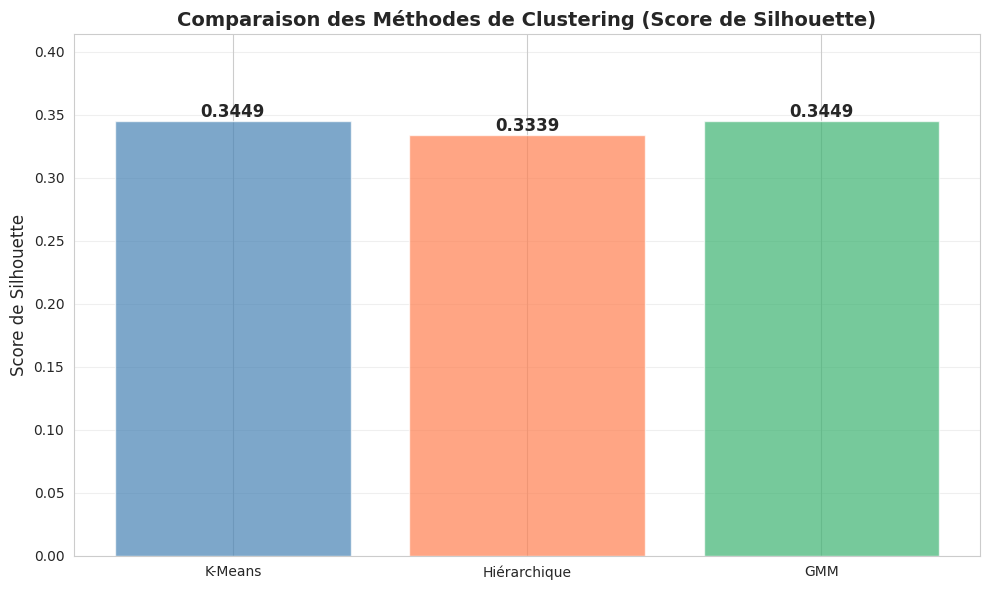


Scores de Silhouette :
K-Means      : 0.3449
Hiérarchique : 0.3339
GMM          : 0.3449


In [32]:
# Comparaison des scores de silhouette pour les trois méthodes
from sklearn.metrics import silhouette_score

methods = ['K-Means', 'Hiérarchique', 'GMM']
scores = [
    silhouette_score(X_scaled, kmeans_labels),
    silhouette_score(X_scaled, hierarchical_labels),
    silhouette_score(X_scaled, gmm_labels)
]

# Visualisation
plt.figure(figsize=(10, 6))
bars = plt.bar(
    methods,
    scores,
    color=['steelblue', 'coral', 'mediumseagreen'],
    alpha=0.7,
    edgecolor='white',
    linewidth=1
)

plt.ylabel('Score de Silhouette', fontsize=12)
plt.title('Comparaison des Méthodes de Clustering (Score de Silhouette)', fontsize=14, fontweight='bold')
plt.ylim(0, max(scores) * 1.2)
plt.grid(True, alpha=0.3, axis='y')

# Afficher les valeurs sur les barres
for bar, score in zip(bars, scores):
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2.,
        height,
        f'{score:.4f}',
        ha='center',
        va='bottom',
        fontsize=12,
        fontweight='bold'
    )

plt.tight_layout()
plt.show()

# Affichage
print('\nScores de Silhouette :')
for method, score in zip(methods, scores):
    print(f'{method:12} : {score:.4f}')

K-Means et GMM sont parfaitement alignés

- → Les clusters sont stables, que vous utilisiez une méthode géométrique (K-Means) ou probabiliste (GMM).

Le clustering hiérarchique est presque aussi bon
- → La légère différence (0.011) est négligeable dans un contexte réel.
Score global > 0.33


In [33]:
# Résumé final
print('='*80)
print('RÉSUMÉ FINAL')
print('='*80)
print(f'\nDataset : {X_scaled.shape[0]} parcelles de riz avec {X_scaled.shape[1]} variables agronomiques')
print(f'Nombre optimal de clusters : 6')
print(f'\nPerformance des méthodes de clustering :')
print(f'  K-Means (score de silhouette)      : {silhouette_score(X_scaled, kmeans_labels):.4f}')
print(f'  Clustering hiérarchique           : {silhouette_score(X_scaled, hierarchical_labels):.4f}')
print(f'  Modèle GMM                        : {silhouette_score(X_scaled, gmm_labels):.4f}')
print(f'\nMeilleure méthode : K-Means / GMM (scores identiques)')
print('='*80)

RÉSUMÉ FINAL

Dataset : 2789 parcelles de riz avec 50 variables agronomiques
Nombre optimal de clusters : 6

Performance des méthodes de clustering :
  K-Means (score de silhouette)      : 0.3449
  Clustering hiérarchique           : 0.3339
  Modèle GMM                        : 0.3449

Meilleure méthode : K-Means / GMM (scores identiques)
